# Filter Bad PairPrice

In [1]:
from modules.stores.StoreTimescaledb import StoreTimescaledb as Store
store = Store()

Active Pairs:   8%|▊         | 621/7732 [01:12<12:42,  9.32 pairs/s, h=2, h%=0.265, f={'neg today': 130, 'len(pp)': 23}]

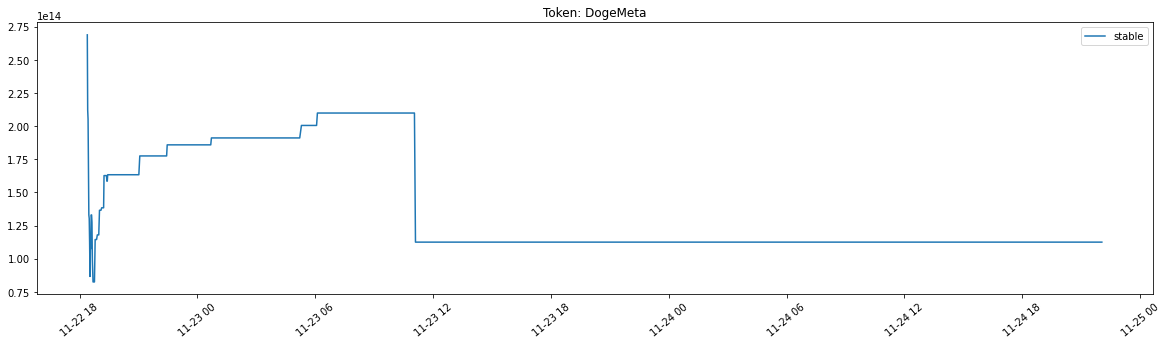

Active Pairs:   8%|▊         | 623/7732 [01:13<19:35,  6.05 pairs/s, h=2, h%=0.265, f={'neg today': 130, 'len(pp)': 23}]

https://www.dextools.io/app/bsc/pair-explorer/0xe535e5443bbB338aEaB636fc3c2C38203a7496f3


Active Pairs:  38%|███▊      | 2904/7732 [05:25<08:37,  9.32 pairs/s, h=7, h%=1.48, f={'neg today': 769, 'len(pp)': 129}]

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import math

from tqdm import tqdm

connection = store.connect()

fig, ax = plt.subplots()  # Create a figure containing a single axes.
fig.set_size_inches(20, 5)

filteredCount = {}
nthCounter = 0
nthHitPlot = 3
hitsFound = 0

# Single entry
targetAddress = "0x5EF4ED3D0fb714B1c1cF15cE372Ed9b805Fa5650"
activePairs = [store.getPairByAddress(targetAddress)]

# List Entry
activePairs = store.getActivePairs(idsOnly = True) # Toggle this
pBar = tqdm(activePairs,  unit =" pairs", desc= "Active Pairs" )

def pbarUpdate():
    pBar.set_postfix({
        'h': hitsFound,
        'h%': ( (100*hitsFound)/len(pairPriceList)), 
        'f' : filteredCount
    })
    
for activePair in pBar:
    
    pairPriceList = store.getPairPrices(activePair)
    if len(pairPriceList) == 0:
        filteredCount["len(pp)"] = filteredCount["len(pp)"] + 1 if "len(pp)" in filteredCount else 1
        pbarUpdate()
        continue
    token = store.getTokenByAddress(pairPriceList[0].targetToken)
    
    y1 = [pairPrice.priceStableCoin for pairPrice in pairPriceList ]
    
    
    
    #----------------------------------------
    # Filters
    #----------------------------------------
    
    # Filter: Last 10% of data is above first 10% of data -- Price is already too negative
    first10PercentValues = y1[( math.floor((len(y1) / 10) * 1 ) ):]
    last10PercentValues = y1[( math.floor((len(y1) / 10) * 9 ) ):]
    
    if  (sum(first10PercentValues) / len(first10PercentValues)) <=  (sum(last10PercentValues) / len(last10PercentValues)):
        filteredCount["neg today"] = filteredCount["neg today"] + 1 if "neg today" in filteredCount else 1
        pbarUpdate()
        continue
    
    # Filter: Average amount of trades per day is above 10 -- No trade activity
    availableTimeframe = (pairPriceList[-1].currentTime - pairPriceList[0].currentTime)
    availableTimeframeInHours,remainder = divmod(availableTimeframe.seconds, 3600)
    availableTimeframeInHours += (availableTimeframe.days * 24) # add hours for all days

    try:
        avgPriceChangesPerHour = ( len(pairPriceList) / (availableTimeframeInHours ) )
    except:
        pass
    
    if avgPriceChangesPerHour < 10:
        filteredCount["delta/hour"] = filteredCount["delta/hour"] + 1 if "delta/hour" in filteredCount else 1
        pbarUpdate()
        continue
    
    # Filter: Sufficient Variance -- Existence of price activity
    # last50PercentValues = [1,2,3,4,5,6,7,8,9,10]
    last50PercentValues = y1[( math.floor(len(y1) / 2) ):]
    avgLast50PercentValues = (sum(last50PercentValues) / len(last50PercentValues))
    
    ## Filter: No Variance -- No price activity
    last50PercentVariance = ( sum([ ( (x - avgLast50PercentValues) ** 2) for x in last50PercentValues]) /  len(last50PercentValues) )
    if last50PercentVariance == 0:
        filteredCount["no var"] = filteredCount["no var"] + 1 if "no var" in filteredCount else 1
        pbarUpdate()
        continue

    ## Filter: Variance above ( 1% ) -- Too little price activity
    last50PercentRelativeVariance = (( 100 * last50PercentVariance)  / avgLast50PercentValues )    
    if last50PercentRelativeVariance < 1:
        filteredCount["little var"] = filteredCount["little var"] + 1 if "little var" in filteredCount else 1
        pbarUpdate()
        continue    
    
    # Filter: Last 25% is above 10% of ATH -- To large of a drop down, dead token
    ath = max(y1)
    last25PercentValues = y1[( math.floor((len(y1) / 4) * 3 ) ):] 
    avgLast25Percent = (sum(last25PercentValues) / len(last25PercentValues)  )
    ## Percentage of ATH
    percentageOfAth  = (( 100 * avgLast25Percent) / ath)
    ## Percentual change of ATH
    percentageChangeOfAth = (avgLast25Percent - ath) / ath
    
    if percentageOfAth < 10:
        filteredCount["smaller ath"] = filteredCount["smaller ath"] + 1 if "smaller ath" in filteredCount else 1
        pbarUpdate()
        continue 
    
    
    
    # Filter: Only show nth hit -- Browsing through hits
    nthCounter+=1
    if nthCounter != nthHitPlot:
        hitsFound += 1
        pbarUpdate()
        continue
    
    
    #----------------------------------------
    # END: Filters
    #----------------------------------------
    
    
    
    
    # Plot Results
    #----------------------------------------
    x = [pairPrice.currentTime for pairPrice in pairPriceList ]
    y2 = [pairPrice.priceUsdt for pairPrice in pairPriceList ]
    ax.plot(x, y1, label='stable')
    # ax.plot(x, y2, label='usdt')
    ax.set_title('Token: ' + token.name)
    ax.xaxis.set_tick_params(rotation=40)
    ax.legend()  # Add a legend.
    plt.show()

    print("https://www.dextools.io/app/bsc/pair-explorer/" + activePair.address)
    # break # only show 1 plot
    
print("Out of " + len(activePairs) + " found " + hitsFound + ": %" + (hitsFound / len(activePairs)))